<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/060922_Exp_1_FSH_Bed_Occupancy_Forecast_TF_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None

In [2]:
#load the data
data = pd.read_csv('/content/fsh_bed.csv', parse_dates=['date'], index_col='date')
data = data[['occupancy']]

In [3]:
data.head()

,occupancy
date,
2016-01-01,0.85
2016-01-02,0.88
2016-01-03,0.91
2016-01-04,0.77
2016-01-05,0.79


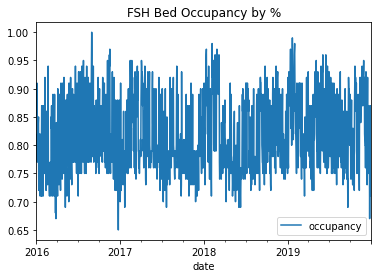

In [5]:
data.plot(title='FSH Bed Occupancy by %')

In [6]:
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(data)
z = scaler.transform(data)

In [17]:
# extract the input sequences and target values
window_size = 60

x, y = [], []

for i in range(window_size, len(z)):
    x.append(z[i - window_size: i])
    y.append(z[i])

x, y = np.array(x), np.array(y)

In [24]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='adam')
model.fit(x, y, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 82ms/step - loss: 0.0807
Epoch 2/100
22/22 [==============================] - 2s 82ms/step - loss: 0.0311
Epoch 3/100
22/22 [==============================] - 2s 79ms/step - loss: 0.0298
Epoch 4/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0296
Epoch 5/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0295
Epoch 6/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0295
Epoch 7/100
22/22 [==============================] - 2s 82ms/step - loss: 0.0296
Epoch 8/100
22/22 [==============================] - 2s 83ms/step - loss: 0.0295
Epoch 9/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0297
Epoch 10/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0294
Epoch 11/100
22/22 [==============================] - 2s 81ms/step - loss: 0.0301
Epoch 12/100
22/22 [==============================] - 2s 80ms/step - loss: 0.0294
Epoch 13/100
22/22 [=====

In [25]:
def multi_step_forecasts(n_past, n_future):

    x_past = x[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    # add the forecasts to the data frame
    df_past = data.rename(columns={'occupancy': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

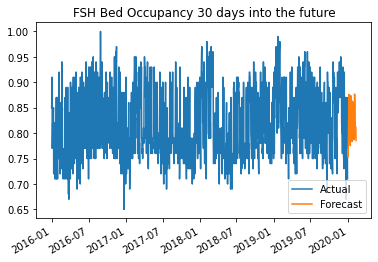

In [26]:
# forecast the next 30 days
df1 = multi_step_forecasts(n_past=0, n_future=30)
df1.plot(title='FSH Bed Occupancy 30 days into the future')

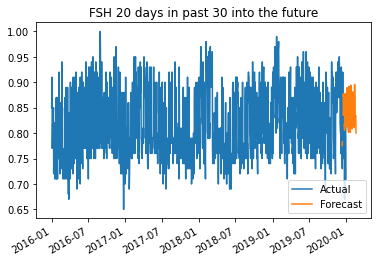

In [27]:
df2 = multi_step_forecasts(n_past=20, n_future=30)
df2.plot(title='FSH 20 days in past 30 into the future')